## TPM Justification

This notebook is made purely for the thermal modeling validation.

For this purpose, I did not use ``accutil.py`` here, except for splines and ``linticker``.

In [1]:
from pathlib import Path
import pickle
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy.table import Table, vstack
from astropy import units as u
from astropy.io import fits
import pandas as pd
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
import yssbtmpy as tm

from matplotlib import pyplot as plt
from matplotlib import rcParams
import warnings
from numba import NumbaPerformanceWarning
from accutil import (QprbarSpline, QprbarSunSpline, linticker, set_perpmodel)
warnings.filterwarnings('ignore', append=True, category=UserWarning)
# warnings.filterwarnings('ignore', append=True, category=NumbaPerformanceWarning)

FIGDIR = Path("./figs")

radii = np.concatenate([np.arange(1, 2, 0.1),
                        np.arange(2.0, 10, 1),
                        np.arange(10, 50, 10)])

In [2]:
# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
rcParams.update({'font.size':12})

## Check Temperature Calculation with Previous Research
[M. Mueller's 2007 PhD thesis (Free University Berlin)](https://arxiv.org/abs/1208.3993) is the primary work I used to make my TPM code. Thus, here I present a manual "checking", i.e., comparing the result from my code and that shown in the thesis. Since the disk-integrated flux is not a part of this work at the current stage, I did not compare with the disk-integrated flux data shown in the thesis.

Mueller's 2007 thesis shows a temperature change over time for a fake asteroid in Fig 2.2:

> The asteroid is situated at a heliocentric distance of r = 1.1 AU, has a spin period of 6 h, a Bond albedo of A = 0.1, and its spin axis is perpendicular to the orbital plane.

The thermal inertias were $ [1,~5] \times 10^{[0,~1,~2,~3,~4]} $ tiu. Here I will only compare the results for 1, 100, 1000, and 10000 tiu for brevity.


I made this fake asteroid by using many dummy variables, except for ``r_hel``, ephemerides such that the aspect angle equals the right angle, ``rot_period`` of 6h, and ``a_bond`` of 0.1.

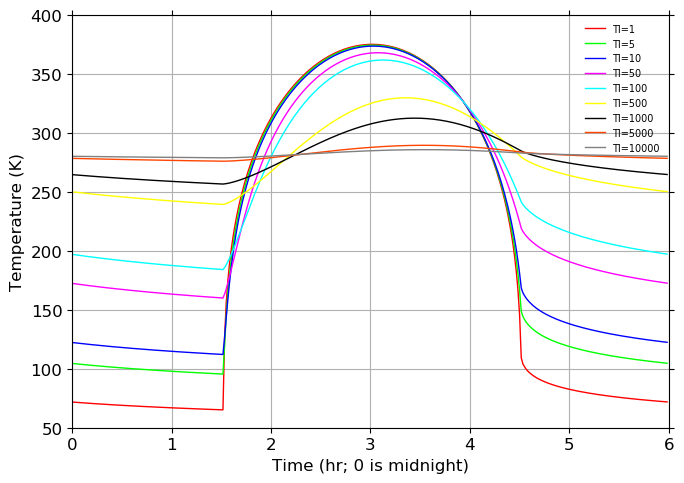

In [3]:
ti_color = {1:'r', 5:'lime', 10:'b', 50:'magenta', 
            100:'cyan', 500:'yellow', 1000:'k', 5000:'orangered', 10000:'gray'}
phis = np.arange(0, 360)
fig, axs = plt.subplots(1, 1, figsize=(7, 5))


for ti, c in ti_color.items():
    sb = tm.SmallBody()

    # Make ephemerides
    sb.set_ecl(r_hel=1.1*u.au, r_obs=1, alpha=0,
               hel_ecl_lon=0, hel_ecl_lat=0,
               obs_ecl_lon=0, obs_ecl_lat=0)

    sb.set_spin(spin_ecl_lon=0,
                spin_ecl_lat=90,  # spin perp to ast-sun vector
                rot_period=6*u.h)

    sb.set_optical(a_bond=0.1,
                   p_vis=1, diam_eff=1, slope_par=tm.pA2G(1, 0.1)) # dummy

    sb.set_thermal(ti=ti, emissivity=0.9)
    sb.set_tpm(nlon=360, nlat=3, Zmax=10, nZ=50)
    sb.calc_temp(full=False)

    axs.plot(phis/60, sb.get_temp(colat__deg=90, lon__deg=phis), 
             color=c, label=f"TI={ti:.0f}", lw=1)

axs.set(ylim=(50, 400), xlim=(0, 6),
        xlabel="Time (hr; 0 is midnight)", ylabel="Temperature (K)")
axs.legend(loc=1, fontsize=7, framealpha=0)
axs.tick_params(right=True, top=True)
axs.grid()
plt.tight_layout()
plt.savefig(FIGDIR/"Mueller_reproduction.png", dpi=200)
plt.show()


On my laptop, I compared the two results like this:

left: the code used here // right: Mueller's Fig 2.2
![](figs/Mueller_Comparison.png)
It can be seen that, e.g., cyan lines (starts and ends only slightly below 200K) and the green lines (starts and ends only slightly above 100K) match well.

## Check Whether Calculations Work Well

There are many internal steps to realize TPM. Here, I will display some intermediate parameters (before the TPM temperature calculation) just for check. I will use (3200) Phaethon as a test object.

In [4]:
true_anom_calc = np.arange(0, 360, 10)  # 360 is not included
tis = np.array([400, 600, 800])

# HanusJ+2018 A&A 620 L8
phys = dict(spin_ecl_lon=318*u.deg, spin_ecl_lat=-47*u.deg,
            rot_period=3.603957*u.h, p_vis=0.12, slope_par=0.15,
            ti=600*tm.TIU, eta_beam=1, emissivity=0.9,
            bulk_mass_den=1670*u.kg/u.m**3,
            diam_eff=5.1*u.km,
            diam_eq=5.1*u.km
            )

tablepath = Path("./phae_ephem.csv")
if tablepath.exists():
    eph_all = Table.read(tablepath)
else:
    epoch_ref = Time(2456049.8189178086, format='jd')  # perihelion: 2012-05-02T07:39:14.499
    epochs_peri = epoch_ref + np.arange(-5, +5, 0.1) * u.day
    epochs_long = dict(start=(epoch_ref - 300.01*u.day).isot,
                       stop=(epoch_ref + 300.01*u.day).isot,
                       step='1d')
    obj_peri = Horizons(id=3200, epochs=epochs_peri.jd)
    obj_long = Horizons(id=3200, epochs=epochs_long)
    eph_peri = obj_peri.ephemerides()
    eph_long = obj_long.ephemerides()

    eph_all = vstack([eph_peri, eph_long])
    eph_all.sort(keys="true_anom")

    pos_ecl = tm.lonlat2cart(lon=eph_all["EclLon"], lat=eph_all["EclLat"])
    spin_ecl = tm.lonlat2cart(lon=phys["spin_ecl_lon"], lat=phys["spin_ecl_lat"])
    eph_all["theta_asp"] = 180 - np.rad2deg(np.arccos(np.inner(pos_ecl.T, spin_ecl)))

# rh, theta_asp as functions of true anomaly:
ks = dict(k=3, s=0)
spl_rh = UnivariateSpline(eph_all["true_anom"], eph_all["r"], **ks)
spl_ro = UnivariateSpline(eph_all["true_anom"], eph_all["delta"], **ks)
spl_asp = UnivariateSpline(eph_all["true_anom"], eph_all["theta_asp"], **ks)
spl_hlon = UnivariateSpline(eph_all["true_anom"], eph_all["EclLon"], **ks)
spl_hlat = UnivariateSpline(eph_all["true_anom"], eph_all["EclLat"], **ks)
spl_olon = UnivariateSpline(eph_all["true_anom"], eph_all["ObsEclLon"], **ks)
spl_olat = UnivariateSpline(eph_all["true_anom"], eph_all["ObsEclLat"], **ks)
spl_alpha = UnivariateSpline(eph_all["true_anom"], eph_all["alpha"], **ks)

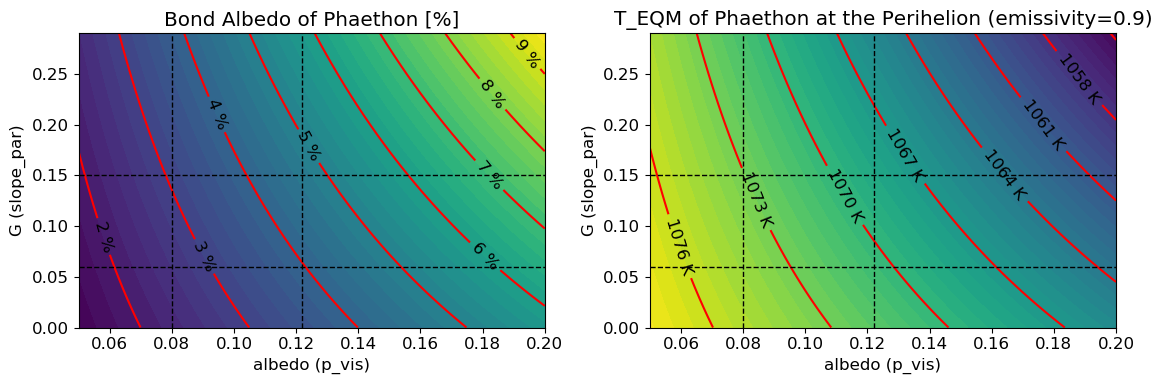

In [5]:
# Set for Perihelion
gs = np.arange(0, 0.3, 0.01)
ps = np.arange(0.05, 0.20, 0.002)
gg, pp = np.meshgrid(gs, ps)
a_bonds = tm.G2q(gg) * pp
a_perc = 100*a_bonds  # in percent
t_eqms = tm.solve_temp_eqm(a_bond=a_bonds,
                           eta_beam=1,
                           r_hel=spl_rh(0),
                           emissivity=0.9)["temp_eqm"]

tmin, tmax = t_eqms.value.min(), t_eqms.value.max()
amin, amax = a_perc.value.min(), a_perc.value.max()
anum, tnum = 8, 8
dt = np.around((tmax - tmin)/tnum, decimals=0)
da = np.around((amax - amin)/anum, decimals=0)

levels_a = np.arange(np.around(amin, 0), amax+da, da)
levels_t = np.arange(np.around(tmin, 0), tmax+dt, dt)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax_a = axs[0]
ax_t = axs[1]

ax_a.contourf(pp, gg, a_perc, levels=50)
cs_a = ax_a.contour(pp, gg, a_perc, levels=levels_a, colors='r')
ax_a.clabel(cs_a, fmt="%.0f %%", colors='k')
ax_a.set(xlabel="albedo (p_vis)",
         ylabel="G (slope_par)",
         title="Bond Albedo of Phaethon [%]")

ax_t.contourf(pp, gg, t_eqms, levels=50)
cs_t = ax_t.contour(pp, gg, t_eqms, levels=levels_t, colors='r')
ax_t.clabel(cs_t, fmt="%.0f K", colors='k')
ax_t.set(xlabel="albedo (p_vis)",
        ylabel="G (slope_par)",
        title="T_EQM of Phaethon at the Perihelion (emissivity=0.9)")

for ax in axs.tolist():
    [ax.axvline(val, color='k', ls='--', lw=1) for val in [0.08, 0.122]]
    [ax.axhline(val, color='k', ls='--', lw=1) for val in [0.06, 0.15]]
plt.tight_layout()

plt.savefig(FIGDIR/"Phaethon_A_TEQM.pdf")
plt.show()


Note that the T_EQM changes only by <~ 1% due to the uncertainty of the albedo and G parameter. This is negligible compared to the seasonal effect presented above. Thus, we just fix these to ``p_vis = 0.12`` and ``slope_par = 0.15``. The TI value, however, is somewhat important because it tunes the night-time temperature rather largely (TI of 600 +- 200 tiu tunes the night temperature 10% or more).

The TI value is uncertain by ~30% (600 +- 200 tiu).

In [6]:
phae = tm.SmallBody()
phae.id = 3200
phae.set_ecl(r_hel=spl_rh(0),
             hel_ecl_lon=spl_hlon(0),
             hel_ecl_lat=spl_hlat(0),
             r_obs=spl_ro(0),
             obs_ecl_lon=spl_olon(0),
             obs_ecl_lat=spl_olat(0),
             alpha=spl_alpha(0)
             )

phae.set_spin(spin_ecl_lon=phys["spin_ecl_lon"],
              spin_ecl_lat=phys["spin_ecl_lat"],
              rot_period=phys["rot_period"])
phae.set_optical(slope_par=phys["slope_par"],
                 diam_eff=phys["diam_eff"],
                 p_vis=phys["p_vis"])
phae.set_mass(diam_eff=phae.diam_eff,
              bulk_mass_den=phys["bulk_mass_den"])
phae.set_thermal(ti=600, emissivity=phys["emissivity"])
phae.set_tpm(nlon=360, nlat=180, Zmax=10, nZ=50)

for k, v in vars(phae).items():
    if k in ["tempsurf", "tempfull", "mu_suns", "tpm_phases", "tpm_colats"]:
        continue
    if v is None:
        print(f"{k:>16s} : None")
    else:
        try:
            print(f"{k:>16s} : {v:10.4g}")
        except (ValueError, TypeError):
            print(f"{k:>16s} : {v}")


phae.calc_temp(full=False)

              id :       3200
    spin_ecl_lon :        318 deg
    spin_ecl_lat :        -47 deg
        spin_vec : [ 0.50682355 -0.45634598 -0.7313537 ]
      rot_period :  1.297e+04 s
       rot_omega :  0.0004843 1 / s
     obs_ecl_lon :      41.17 deg
     obs_ecl_lat :     -2.128 deg
     hel_ecl_lon :      229.5 deg
     hel_ecl_lat :     -13.43 deg
           r_hel :     0.1396 AU
       r_hel_vec : [-0.08814953 -0.10332293 -0.03244059] AU
           r_obs :      0.874 AU
       r_obs_vec : [ 0.65747262  0.57492092 -0.03244653] AU
       phase_ang :      162.3 deg
      aspect_ang :      100.8 deg
        hmag_vis :      14.38
       slope_par :       0.15
       phase_int :     0.3844
        diam_eff :       5100 m
        radi_eff :       2550 m
           p_vis :       0.12
          a_bond :    0.04613
            mass :   1.16e+14 kg
   bulk_mass_den :       1670 kg / m3
acc_grav_equator :   0.001191 m / s2
   v_esc_equator :      2.464 m / s
              ti :        600

We fix 
* albedo-related parameters: ``p_vis`` as 0.12 & ``slope_par`` as 0.15 (thus ``a_bond`` as 0.046), 
* spin-related parameters: spin direction, ``rot_period``,
* thermal-related parameters: ``emissivity`` as 0.9, ``ti`` as 600 tiu, no roughness (i.e., ``eta_beam`` of unity).

## Temperature (Surface VS 1-skin-depth)

For comparison, I did the full calculation at deeper regions.

Then plotted the temperature on the surface and at 1-thermal skin depth.

Here I used perpendicular model, not Phaethon.

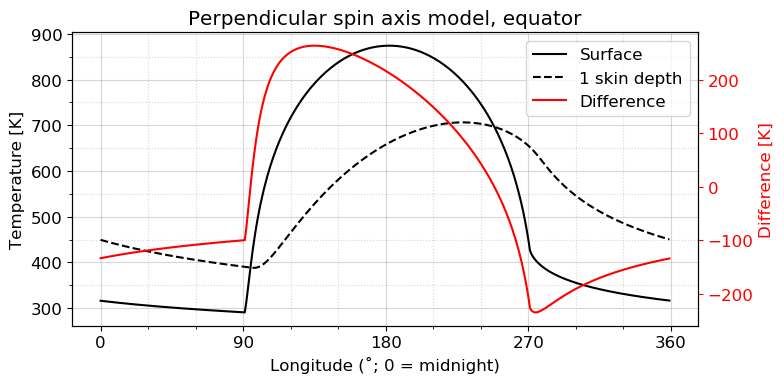

In [7]:
TPM_PERP = dict(rot_period=6*u.h, 
                r_hel=0.2*u.au,
                a_bond=0.1, 
                ti=200, 
                bulk_mass_den=2000*u.kg/u.m**3, 
                emissivity=0.90,
                nlon=360,
                nlat=3)

perpmodel = set_perpmodel(diam_eff=1*u.km, **TPM_PERP)
perpmodel.calc_temp(full=True)
temp_surf = perpmodel.tempsurf[1, :] * perpmodel.temp_eqm
temp_skindepth = perpmodel.tempfull[1, :, int(1/perpmodel.dZ)] * perpmodel.temp_eqm

fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

axs.plot(temp_surf, 'k-', label="Surface")
axs.plot(temp_skindepth, 'k--', label="1 skin depth")
axs.plot([np.nan], [np.nan], 'r', label="Difference")
axs.set(xlabel="Longitude (˚; 0 = midnight)",
        ylabel="Temperature [K]",
        title="Perpendicular spin axis model, equator")
axs.legend()

ax2 = axs.twinx()
ax2.plot(temp_surf - temp_skindepth, 'r')
ax2.set_ylabel("Difference [K]", color='r')
ax2.tick_params(colors='r')


linticker(axs, xmajlockws=90, ymajlockws=100, xminlockws=30, yminlockws=50)
plt.tight_layout()
plt.show()

## Phaethon's Temperature Map at Its Perihelion

For the test object (3200) Phaethon, calculate and display the temperature map (as a function of longitude and colatitude) at its perihelion. The longitude starts from the midnight.

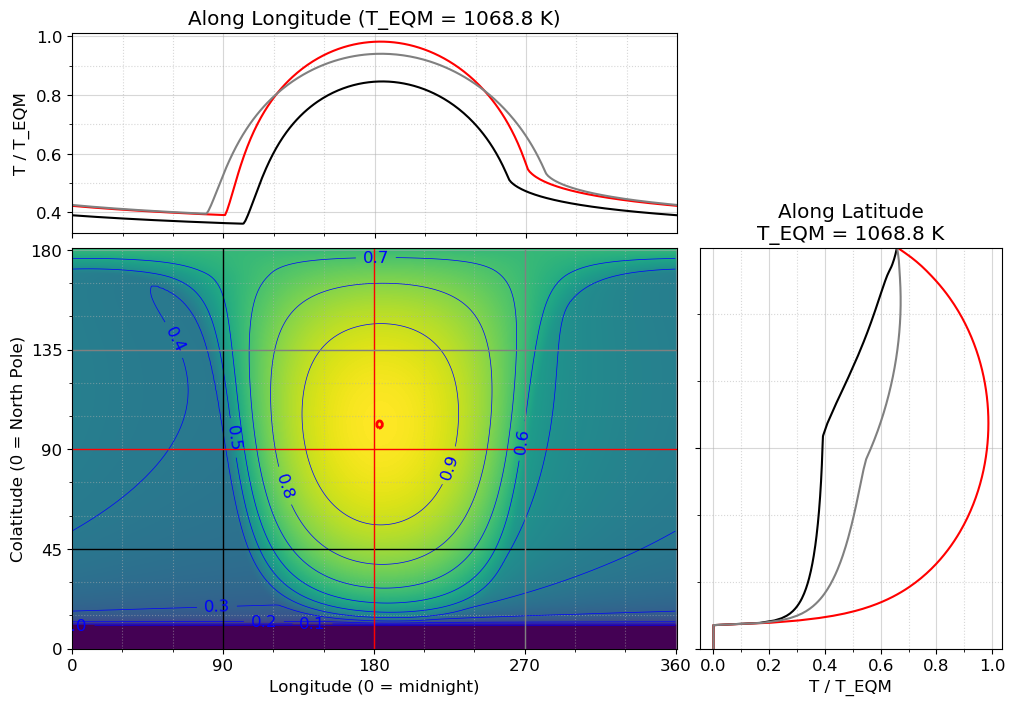

In [8]:
colats_plot = np.arange(0, 180, 0.1)
phases_plot = np.arange(0, 360, 0.1)
extents = (phases_plot.min(), phases_plot.max()+1,
           colats_plot.min(), colats_plot.max()+1)
colors_cut = ["k", "r", "grey"]
colats_cut = [45, 90, 135]
phases_cut = [90, 180, 270]
temps = phae.spl_temp(colats_plot, phases_plot)

fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        gridspec_kw={'height_ratios':[1, 2],
                                     'width_ratios':[2, 1],
                                     'wspace':0.05, 'hspace':0.05})
ax_h = axs[0, 0]
ax_v = axs[1, 1]
ax_i = axs[1, 0]
ax_h.set(ylabel="T / T_EQM",
         title=f"Along Longitude (T_EQM = {phae.temp_eqm:.1f})",
         xlim=(phases_plot.min(), phases_plot.max()))
ax_h.tick_params(labelbottom=False)
ax_v.set(xlabel="T / T_EQM",
         title=f"Along Latitude\nT_EQM = {phae.temp_eqm:.1f}",
         ylim=(colats_plot.min(), colats_plot.max()))
ax_v.tick_params(labelleft=False)
ax_i.set(xlabel="Longitude (0 = midnight)",
         ylabel="Colatitude (0 = North Pole)")
_ = axs[0, 1]
_.axis('off')

ax_i.imshow(temps, extent=extents, origin='lower', aspect='auto')
cs = ax_i.contour(phases_plot, colats_plot, temps,
                  levels=np.arange(0, 1.1, 0.1),
                  colors='b', linewidths=0.5)
ax_i.clabel(cs, fmt="%.1f", inline=1)
cs2 = ax_i.contour(phases_plot, colats_plot, temps,
                   levels=[temps.max() - 1.e-4],
                   colors='r', linewidths=2)
#ax_i.clabel(cs2, fmt="Max", inline=1)

for col, ph, c in zip(colats_cut, phases_cut, colors_cut):
    ax_h.plot(phases_plot, phae.spl_temp(col, phases_plot).flatten(), color=c)
    ax_v.plot(phae.spl_temp(colats_plot, ph).flatten(), colats_plot, color=c)
    ax_i.axhline(col, color=c, ls='-', lw=1)
    ax_i.axvline(ph, color=c, ls='-', lw=1)

linticker(ax_list=[ax_i, ax_h, ax_v],
          xmajlockws=[90, 90, 0.2],
          xminlockws=[30, 30, 0.1],
          ymajlockws=[45, 0.2, 90],
          yminlockws=[15, 0.1, 30],
          xmajfmtkws=["%.0f", "%.0f", "%.1f"],
          ymajfmtkws=["%.0f", "%.1f", "%.0f"]
         )

plt.tight_layout()
plt.savefig(FIGDIR/"Phaethon_temp_map_perih.pdf")
plt.savefig(FIGDIR/"Phaethon_temp_map_perih.png")

## Calculation Speed Thanks to ``numba`` Parallel Option

In [9]:
%%timeit
sb = tm.SmallBody()

# Make fake ephemerides
sb.set_ecl(r_hel=3*u.au, # only this is meaningful
           r_obs=1, alpha=0,
           hel_ecl_lon=0, hel_ecl_lat=0,
           obs_ecl_lon=0, obs_ecl_lat=0)

sb.set_spin(spin_ecl_lon=0,
            spin_ecl_lat=90,  # spin perp to ast-sun vector
            rot_period=4*u.h)

sb.set_optical(p_vis=0.2, slope_par=0.1, diam_eff=1)

sb.set_thermal(ti=800, emissivity=0.9)
sb.set_tpm(nlon=360, nlat=180, Zmax=10, nZ=50)
sb.calc_temp(full=False)

print("thermal parameter: ", sb.thermal_par)

thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
thermal parameter:  27.22861594301891
521 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For thermal parameter $\Theta = 27.2$, When there is **no parallel** option in ``numba`` (see ``yssbtmpy.util.setup_uarr_tpm``)

    4.87 s ± 59.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    5.02 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

When the **parallel** option is turned on:

    537 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    525 ms ± 24.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    529 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

It's ~10 times faster if parallel mode is used. This ratio depends on your environment. 

Also this parallel is more **efficient when ``nlat`` is larger**, and it doesn't depend much on ``nlon``, because it's fundamentally impossible to make calculation parallel along the longitude (``nlon``).